In [16]:
from gsplat.rendering import rasterization, rasterization_inria_wrapper
from examples.utils import rgb_to_sh
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from plyfile import PlyData

import struct
import array
import numpy as np
from pycolmap.rotation import Quaternion
from pycolmap.image import Image
from collections import OrderedDict

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sh_degree = 3



In [20]:
def load_images_bin(input_file):
    images = OrderedDict()
    name_to_image_id = dict()
    last_image_id = 0
    images_id = []
    with open(input_file, 'rb') as f:
            num_images = struct.unpack('L', f.read(8))[0]
            image_struct = struct.Struct('<I 4d 3d I')
            for _ in range(num_images):
                data = image_struct.unpack(f.read(image_struct.size))
                image_id = data[0]
                images_id.append(image_id)
                q = Quaternion(np.array(data[1:5]))
                t = np.array(data[5:8])
                camera_id = data[8]
                name = b''.join(c for c in iter(lambda: f.read(1), b'\x00')).decode()

                image = Image(name, camera_id, q, t)
                num_points2D = struct.unpack('Q', f.read(8))[0]

                # Optimized code below.
                # Read all elements as double first, then convert to array, slice it
                # into points2d and ids, and convert ids back to unsigned long longs
                # ('Q'). This is significantly faster than using O(num_points2D) f.read
                # calls, experiments show >7x improvements in 60 image model, 23s -> 3s.
                points_array = array.array('d')
                points_array.fromfile(f, 3 * num_points2D)
                points_elements = np.array(points_array).reshape((num_points2D, 3))
                image.points2D = points_elements[:, :2]

                ids_array = array.array('Q')
                ids_array.frombytes(points_elements[:, 2].tobytes())
                image.point3D_ids = np.array(ids_array, dtype=np.uint64).reshape(
                    (num_points2D,))


                images[image_id] = image
                name_to_image_id[image.name] = image_id

                last_image_id = max(last_image_id, image_id)
    return images, images_id, name_to_image_id, last_image_id

In [21]:
image_bin_path = "../data/tandt/train/sparse/0/images.bin"
images, images_id, name_to_image_id, last_image_id = load_images_bin(image_bin_path)
print(len(images_id))

301


In [23]:
images0 = images[images_id[0]]
print(images0.name)
print(images0.camera_id)
print(images0.q)
print(images0.tvec)

00001.jpg
1
[ 0.96828768 -0.0220472  -0.24703143  0.03013925]
[0.83072447 0.42330418 4.72019668]


In [25]:
R = images0.q.ToR()
print(R)

t = images0.tvec.reshape(3, 1)
print(t)
bottom = np.array([0, 0, 0, 1]).reshape(1, 4)
w2c = np.concatenate([np.concatenate([R, t], 1), bottom], axis=0)

print(w2c)

c2w = np.linalg.inv(w2c)
print(c2w)

[[ 0.8761342  -0.04747422 -0.47972394]
 [ 0.06925962  0.99721109  0.02780538]
 [ 0.477066   -0.05758674  0.87697879]]
[[0.83072447]
 [0.42330418]
 [4.72019668]]
[[ 0.8761342  -0.04747422 -0.47972394  0.83072447]
 [ 0.06925962  0.99721109  0.02780538  0.42330418]
 [ 0.477066   -0.05758674  0.87697879  4.72019668]
 [ 0.          0.          0.          1.        ]]
[[ 0.8761342   0.06925962  0.477066   -3.00898935]
 [-0.04747422  0.99721109 -0.05758674 -0.1108649 ]
 [-0.47972394  0.02780538  0.87697879 -3.75276409]
 [ 0.          0.          0.          1.        ]]


In [27]:
camera_path = "../results/tandt/train/colmap/colmap_camera.npy"
camera_data = np.load(camera_path, allow_pickle=True).item()
camtoworlds = camera_data["camtoworlds"]
c2w = torch.from_numpy(camtoworlds[0]).float().to(device)
print(c2w)
viewmat = c2w.inverse()
print(viewmat)

tensor([[ 0.8572, -0.3793, -0.3484,  0.3566],
        [ 0.4394,  0.1857,  0.8789, -1.3837],
        [-0.2687, -0.9065,  0.3258, -0.2371],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
tensor([[ 8.5718e-01,  4.3939e-01, -2.6866e-01,  2.3856e-01],
        [-3.7929e-01,  1.8570e-01, -9.0645e-01,  1.7727e-01],
        [-3.4840e-01,  8.7889e-01,  3.2583e-01,  1.4176e+00],
        [ 4.3739e-09,  1.8835e-08,  3.8759e-09,  1.0000e+00]], device='cuda:0')


In [ ]:
import json
camera_path = "../results_3dgs/train/cameras.json"
camera_data = json.load(open(camera_path))[0]
rotate = np.array(camera_data["rotation"])
print(rotate)
trans = np.array(camera_data["position"])
print(trans)
c2w = np.eye(4)
c2w[:3, :3] = rotate
c2w[:3, 3] = trans
print(c2w)
w2c = np.linalg.inv(c2w)
print(w2c)

[[ 0.8761342   0.06925962  0.477066  ]
 [-0.04747422  0.99721109 -0.05758674]
 [-0.47972394  0.02780538  0.87697879]]
[-3.00898935 -0.1108649  -3.75276409]
[[ 0.8761342   0.06925962  0.477066   -3.00898935]
 [-0.04747422  0.99721109 -0.05758674 -0.1108649 ]
 [-0.47972394  0.02780538  0.87697879 -3.75276409]
 [ 0.          0.          0.          1.        ]]
[[ 0.8761342  -0.04747422 -0.47972394  0.83072447]
 [ 0.06925962  0.99721109  0.02780538  0.42330418]
 [ 0.477066   -0.05758674  0.87697879  4.72019668]
 [ 0.          0.          0.          1.        ]]


In [ ]:
width, height = 1280, 960
FOV = 50*np.pi/180
focal_length = height / 2.0 / np.tan(FOV / 2.0)
Ks = np.array(
        [
            [focal_length, 0.0, width / 2.0],
            [0.0, focal_length, height / 2.0],
            [0.0, 0.0, 1.0],
        ]
    )
Ks = torch.from_numpy(Ks).float().to(device)

In [11]:
world_view_transform = viewmat.transpose(0, 1)
print(world_view_transform)

camera_center = world_view_transform.inverse()[3, :3]
print(camera_center)

tensor([[ 8.5718e-01, -3.7929e-01, -3.4840e-01,  4.3739e-09],
        [ 4.3939e-01,  1.8570e-01,  8.7889e-01,  1.8835e-08],
        [-2.6866e-01, -9.0645e-01,  3.2583e-01,  3.8759e-09],
        [ 2.3856e-01,  1.7727e-01,  1.4176e+00,  1.0000e+00]], device='cuda:0')
tensor([ 0.3566, -1.3837, -0.2371], device='cuda:0')


In [3]:
def load_ply_to_gsplat_vars(path, max_sh_degree=3, device="cuda"):
    plydata = PlyData.read(path)

    # means
    xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                    np.asarray(plydata.elements[0]["y"]),
                    np.asarray(plydata.elements[0]["z"])), axis=1)
    means = torch.tensor(xyz, dtype=torch.float, device=device)

    # opacities
    opacities = np.asarray(plydata.elements[0]["opacity"])
    opacities = torch.tensor(opacities, dtype=torch.float, device=device).squeeze()
    opacities = torch.sigmoid(opacities)

    # sh0
    features_dc = np.zeros((xyz.shape[0], 3, 1))
    features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
    features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
    features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])
    sh0 = torch.tensor(features_dc, dtype=torch.float, device=device).transpose(1, 2).contiguous()

    # shN
    extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
    extra_f_names = sorted(extra_f_names, key=lambda x: int(x.split('_')[-1]))
    features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
    for idx, attr_name in enumerate(extra_f_names):
        features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
    features_extra = features_extra.reshape((features_extra.shape[0], 3, (max_sh_degree + 1) ** 2 - 1))
    shN = torch.tensor(features_extra, dtype=torch.float, device=device).transpose(1, 2).contiguous()

    # scales
    scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
    scale_names = sorted(scale_names, key=lambda x: int(x.split('_')[-1]))
    scales = np.zeros((xyz.shape[0], len(scale_names)))
    for idx, attr_name in enumerate(scale_names):
        scales[:, idx] = np.asarray(plydata.elements[0][attr_name])
    scales = torch.tensor(scales, dtype=torch.float, device=device)
    scales = torch.exp(scales)

    # quats
    rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
    rot_names = sorted(rot_names, key=lambda x: int(x.split('_')[-1]))
    rots = np.zeros((xyz.shape[0], len(rot_names)))
    for idx, attr_name in enumerate(rot_names):
        rots[:, idx] = np.asarray(plydata.elements[0][attr_name])
    quats = torch.tensor(rots, dtype=torch.float, device=device)
    quats = F.normalize(quats, p=2, dim=-1)

    return means, quats, scales, opacities, sh0, shN


In [4]:
def load_gsplat_vars(ckpt_path, device="cuda"):
    ckpt = torch.load(ckpt_path, map_location=device)["splats"]
    means = ckpt["means"]   
    quats = F.normalize(ckpt["quats"], p=2, dim=-1)
    scales = torch.exp(ckpt["scales"])
    opacities = torch.sigmoid(ckpt["opacities"])
    sh0 = ckpt["sh0"]
    shN = ckpt["shN"]
    return means, quats, scales, opacities, sh0, shN

In [5]:
# # load ply file
# ply_filepath = "../results/train/iteration_7000/point_cloud.ply"

# means, quats, scales, opacities, sh0, shN = load_ply_to_gsplat_vars(ply_filepath, device=device)
# colors = torch.cat([sh0, shN], dim=-2)

In [5]:
# load gsplat vars
ckpt_path = "../results/tandt/train/ckpts/ckpt_29999_rank0.pt"
means, quats, scales, opacities, sh0, shN = load_gsplat_vars(ckpt_path, device=device)
colors = torch.cat([sh0, shN], dim=-2)

In [7]:
# # random gsplat vars
# means = torch.randn((100, 3), device=device)
# quats = torch.randn((100, 4), device=device)
# scales = torch.rand((100, 3), device=device) * 0.1
# sh0 = torch.randn((100, 1, 3), device=device)*0.3 + 0.5
# sh0 = rgb_to_sh(torch.clamp(sh0, 0, 1))
# shN = torch.zeros((100, 15,3), device=device)
# colors = torch.cat([sh0, shN], dim=-2)
# opacities = torch.rand((100,), device=device)


In [6]:
print(means.shape, means.device)
print(quats.shape, quats.device)
print(scales.shape, scales.device)
print("range of scales", scales.min(), scales.max())
print(opacities.shape, opacities.device)
print("range of opacities", opacities.min(), opacities.max())
print(sh0.shape, sh0.device)
print("range of sh0", sh0.min(), sh0.max())
print(shN.shape, shN.device)
print(colors.shape, colors.device)

torch.Size([1122613, 3]) cuda:0
torch.Size([1122613, 4]) cuda:0
torch.Size([1122613, 3]) cuda:0
range of scales tensor(6.8411e-09, device='cuda:0') tensor(5.2693, device='cuda:0')
torch.Size([1122613]) cuda:0
range of opacities tensor(0.0008, device='cuda:0') tensor(1., device='cuda:0')
torch.Size([1122613, 1, 3]) cuda:0
range of sh0 tensor(-2.4355, device='cuda:0') tensor(8.5274, device='cuda:0')
torch.Size([1122613, 15, 3]) cuda:0
torch.Size([1122613, 16, 3]) cuda:0


In [7]:
with torch.no_grad():
    render_colors, alphas, meta = rasterization_inria_wrapper(
                                means, quats, scales, opacities, colors, 
                                viewmat[None], 
                                Ks[None], 
                                width, height, 
                                sh_degree=sh_degree
    )
print(render_colors.shape)

torch.Size([1, 960, 1280, 3])


1.4328387 1.9400797e-05


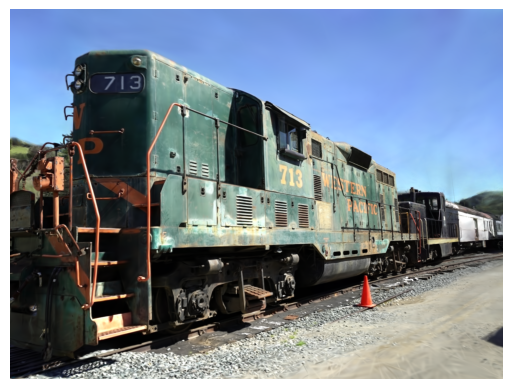

In [8]:
image = render_colors[0, ...].cpu().numpy()
print(np.max(image), np.min(image))
plt.imshow(image.clip(0, 1))
plt.axis("off")
plt.show()

In [ ]:
with torch.no_grad():
    render_colors, alphas, meta = rasterization(
                            means, quats, scales, opacities, colors, 
                            viewmat[None], 
                            Ks[None], 
                            width, height, sh_degree=sh_degree)
print(render_colors.shape)

torch.Size([1, 960, 1280, 3])


1.143051 8.234489e-05


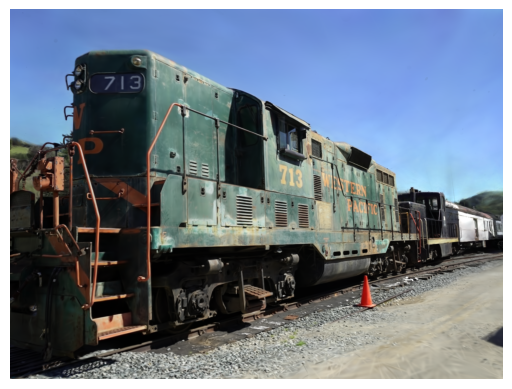

In [12]:
image = render_colors[0,...].cpu().numpy()
print(np.max(image), np.min(image))
plt.imshow(image.clip(0, 1))
plt.axis("off")
plt.show()